# Product Quantities Analysis and Forecasting Using Linear Regression

Name : Happy Trianna\
Batch : FTDS RMT 018

## Objective

- Analyze the number of sales per week each year
- Analyze the number of times sales are made per week
- Predicting the number of products sold in the next period
- Determining the best linear regression model to predict the quantity of products sold

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from scipy.stats import skew

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## Data Loading

In [2]:
# Loading the data into df
df = pd.read_csv('sample_dataset_timeseries_noarea.csv')

# Preview the head of the data
df.head()

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119


In [3]:
# Preview the tail of the data
df.tail()

,week_number,week_start_date,week_end_date,product_item,quantity
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920
102732,2023-14,2023-04-03,2023-04-09,fff18f7c705e729746515e2053dee64b,53


In [4]:
# Viewing the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


week_start_date and week_end_date has a object data type, we need to change this into datetime.

In [5]:
# Change the data type of the date into datetime
df['week_start_date']=pd.to_datetime(df['week_start_date'])
df['week_end_date']=pd.to_datetime(df['week_end_date'])

# viewing the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   week_number      102733 non-null  object        
 1   week_start_date  102733 non-null  datetime64[ns]
 2   week_end_date    102733 non-null  datetime64[ns]
 3   product_item     102731 non-null  object        
 4   quantity         102733 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 3.9+ MB


## Exploratory Data Analysis

First, we need to check rather the data has been duplicated or not.

In [6]:
# Check duplicated data from original data
df.duplicated().value_counts()

False    102733
dtype: int64

There is no duplicated data in our dataset.

In [7]:
# Print the range of data based on the first day of the week
print ("First data recorded on", df['week_start_date'].min().strftime('%d %B %Y'))
print ("Recent data recorded on", df['week_end_date'].max().strftime('%d %B %Y'))

First data recorded on 27 December 2021
Recent data recorded on 09 April 2023


The first data are recorded on the last week of 2021, while the most recent data are recorded right before we make this project, 9 April 2023.

In [8]:
# Check the unique item of the products and the total sold unique products
print ("Preview of unique item sold :",df.product_item.unique())
print ("\nTotal unique item sold =",df.product_item.nunique())

Preview of unique item sold : ['0073377087c7ddace313ff829cd7b0b3' '012d2bb142b2d5e57330acbfd8e9ac52'
 '0192926e33d1153b63511a5b83eca843' ... 'b86ac140782a3ec0662fc3a2b7c30590'
 'c26bb0ce75e31e6c29aae7056c8bbce6' 'ff9d05a4d6f922b3ab1653f58165b8ce']

Total unique item sold = 2309


- The unique item name is written in a code and `there is no further information on each item`, so we won't analyze the sold quantities for each item
- Total of unique products sold are 2309 items.

In [9]:
# Get the week and year of the week_number column

df['week'] = pd.to_numeric(df['week_number'].apply(lambda x: x[-2:]))
df['year'] = pd.to_numeric(df['week_number'].apply(lambda x: x[:-3]))
df

,week_number,week_start_date,week_end_date,product_item,quantity,week,year
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41,52,2021
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430,52,2021
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4,52,2021
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148,52,2021
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119,52,2021
...,...,...,...,...,...,...,...
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907,14,2023
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81,14,2023
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16,14,2023
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920,14,2023


<Axes: title={'center': 'Number of Week For All Years'}, xlabel='week_start_date'>

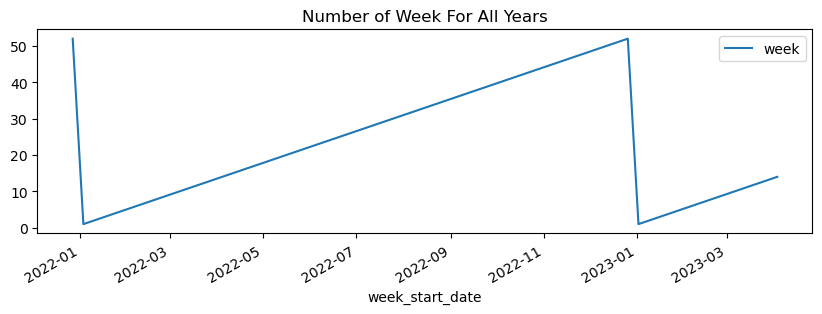

In [10]:
# plot to see the sequence of timeseries data
df[['week_start_date','week']].set_index('week_start_date').plot(figsize=(10,3), title='Number of Week For All Years')

As we can see from the sequence of week number for each year, `our data is already sorted in timeseries`, so we don't need to sort the data by the number of the week for each year.

In [11]:
# Quantities of product sold per week
df.groupby('week_start_date')['quantity'].sum().describe()

count    6.700000e+01
mean     4.893713e+06
std      1.044439e+06
min      1.288080e+05
25%      4.337716e+06
50%      4.907074e+06
75%      5.619344e+06
max      7.172144e+06
Name: quantity, dtype: float64

It shows that the total of products sold per week are around 4.9M in 50% percentile and mean of the data, while the maximum sold per week are 7.1M and minimum sold are 1.2M.

Text(0.5, 1.0, 'Number of Times Sales Per Week')

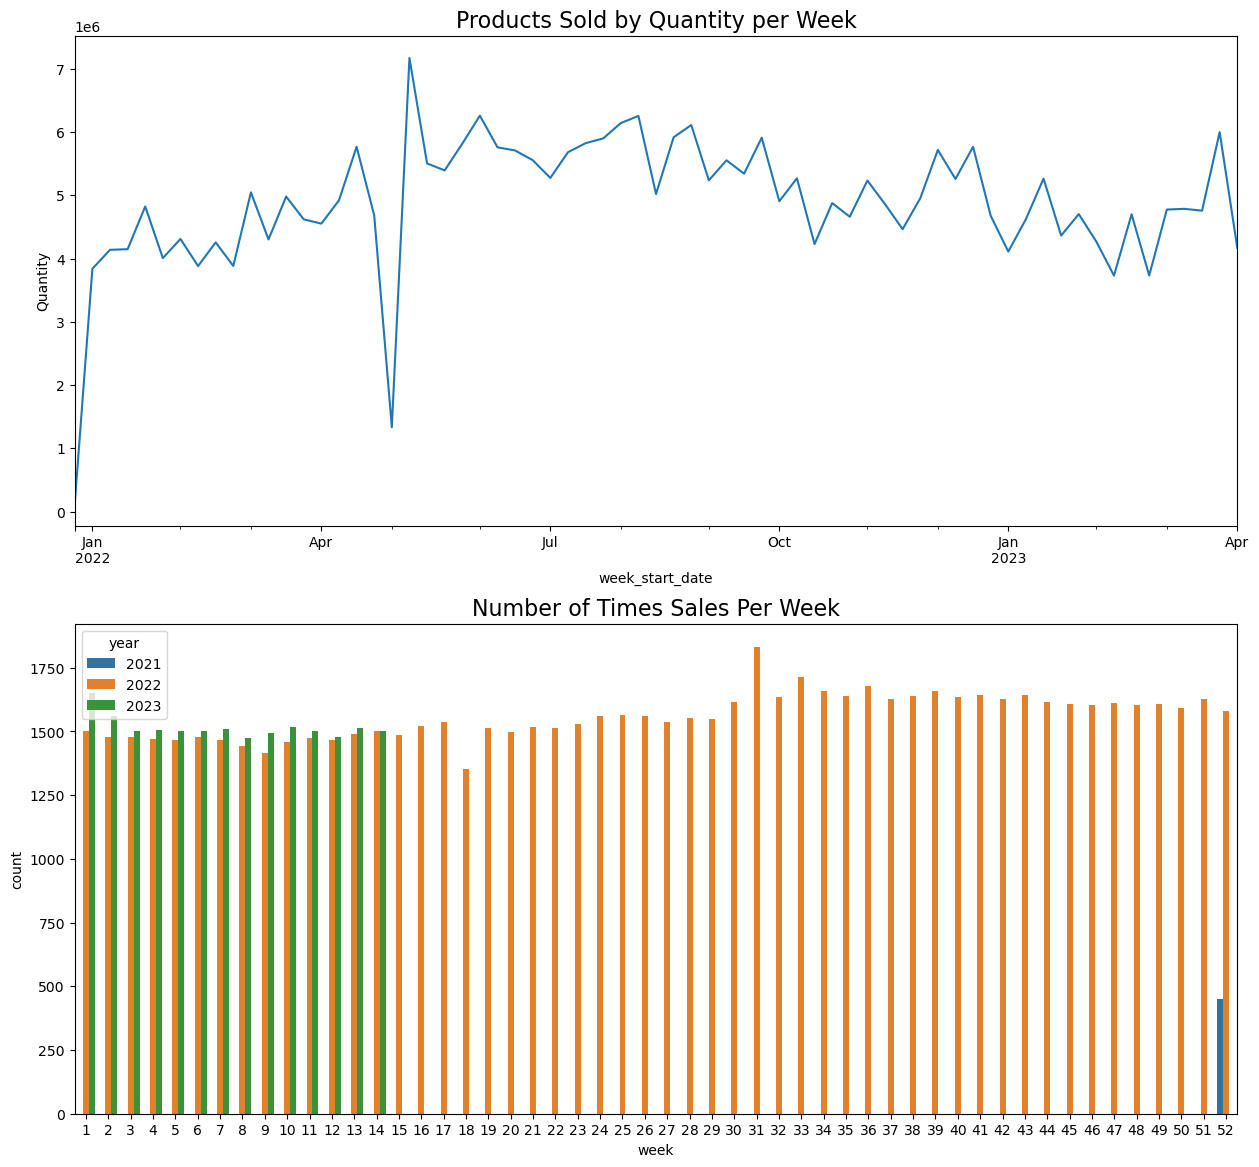

In [12]:
# Plot of number of sales and sum of products sold
fig, ax = plt.subplots(nrows=2,figsize=(15,14))
df.groupby('week_start_date')['quantity'].sum().plot(ax=ax[0])
ax[0].set_ylabel('Quantity')
ax[0].set_title("Products Sold by Quantity per Week", fontsize=16)

sns.countplot(data=df, x="week", hue="year", ax=ax[1])
ax[1].set_title("Number of Times Sales Per Week", fontsize=16)

Now, before analyze the graphs above, we will first look into the date from `18th week of year 2022` where the lowest number of times sales happen.

In [13]:
# Get the date of week 18 from year 2022
print (datetime.datetime.strptime('2022-18' + '-1', "%Y-%W-%w"))

2022-05-02 00:00:00


- In 2022, `sales in week 18`, or the first week of May, appear to be `lower than in other weeks`, judging by the appearance of fewer products sold than in other weeks. `May 2nd, 2022 coincided with Eid al-Fitr`, so we assumed that `many employees were not working` during the collective leave schedule, resulting in less productivity than usual. The impact of total numbers of sales decreasing, `resulting in a drastic decrease in the number of products sold`, dropped to 1.2M.

- In 2021, it appears that the total number of sales is much less than in other weeks, it can be assumed that `December 27` is the date `when the initial product sales are recorded`, so it is possible that the data at the beginning is incomplete or the sales promotion has just started. 

In [14]:
# Check the maximum and minimum quantities of each sold item
df['product_item'].value_counts()

0073377087c7ddace313ff829cd7b0b3    67
870b3ad8c41b746b29ba31f6e4040950    67
9264576b8833b892b34a39525bcdd271    67
921cfbd1930eeee6b82a7b053c4ed8dc    67
91f65f29b32c39788b4294cbe2be7024    67
                                    ..
d97d3a3e53124b6b1a8313403f54f6b8     1
d963020bd8d76659c6768ad252be9629     1
d4e90f2dcbcf53757d6bd1f3b6f368cb     1
170ad92bf82a3509886ceb841cd6e3c3     1
ff9d05a4d6f922b3ab1653f58165b8ce     1
Name: product_item, Length: 2309, dtype: int64

- Maximum items sold for each product are 67
- Minimum items sold for each product is 1

## Feature Engineering

### Check Missing Value

In [15]:
# Select the quantity, week_start_date, and week number of the data
week_quantity=df.groupby(['week_start_date','week'])['quantity'].sum().reset_index(name='quantity')
week_quantity

,week_start_date,week,quantity
0,2021-12-27,52,128808
1,2022-01-03,1,3839557
2,2022-01-10,2,4138934
3,2022-01-17,3,4149077
4,2022-01-24,4,4824273
...,...,...,...
62,2023-03-06,10,4775638
63,2023-03-13,11,4787111
64,2023-03-20,12,4757590
65,2023-03-27,13,6001166


In [16]:
# Check the missing value
week_quantity.isnull().mean()

week_start_date    0.0
week               0.0
quantity           0.0
dtype: float64

There is no missing value.

### Handling Outlier

In timeseries of a data, we need to check rather the stored data is the real data that can be used directly to the model or not. It is natural to ask the provider of the data to make sure whether the data obtained has errors when stored. Usually, we will change the data in the time series as original as possible with the data obtained if there is outlier data. We won't use any transformer tools to handle the outlier, hence we will do it before splitting the data into train and test set.

In [17]:
def find_skewed_boundaries(df, variable, distance,skew):
    
    if ((skew>=0.5) | (skew<=-0.5)):
    
        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

        lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
        
    else:
        lower_boundary=df[variable].mean() - (df[variable].std()*3)
        upper_boundary=df[variable].mean() + (df[variable].std()*3)
        
    return upper_boundary, lower_boundary

# Function to create histogram and boxplot.
# This functions takes a dataframe (df) and the variable of interest as arguments.

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

quantity
% Upper Outlier for quantity : 0.00%
% Lower Outlier for quantity : 2.99%
Skewness of quantity : -1.81


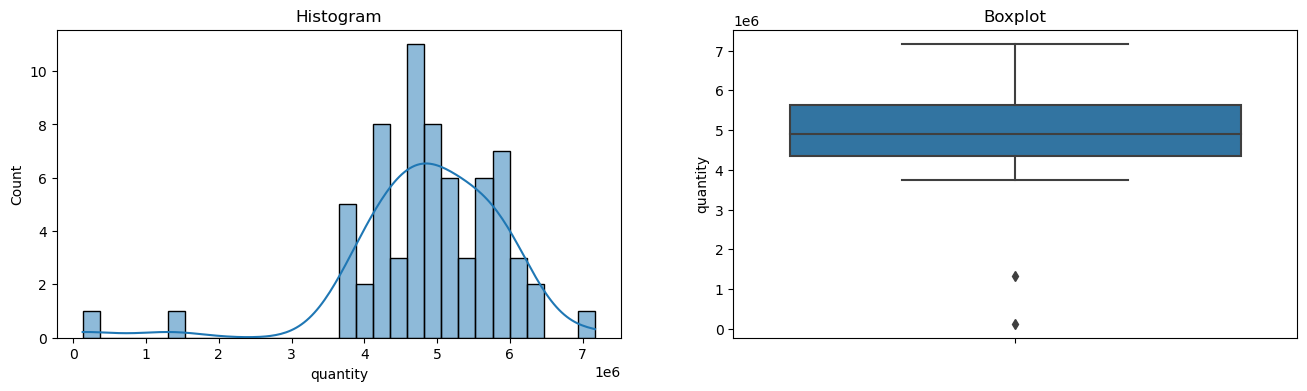

In [18]:
# Check the outlier in the data

upper, lower=find_skewed_boundaries(week_quantity, 'quantity', 1.5, week_quantity['quantity'].skew())

out_u=(len(week_quantity[week_quantity['quantity'] > upper])/len(week_quantity) * 100)
out_l=(len(week_quantity[week_quantity['quantity'] < lower])/len(week_quantity) * 100)

print('quantity')
print('% Upper Outlier for quantity : {:.2f}%'.format(out_u))
print('% Lower Outlier for quantity : {:.2f}%'.format(out_l))
print('Skewness of quantity : {:.2f}'.format(week_quantity['quantity'].skew()))
diagnostic_plots(week_quantity, 'quantity')

In [19]:
# Check the location of outlier in our dataset
week_quantity[week_quantity['quantity'] < lower]

,week_start_date,week,quantity
0,2021-12-27,52,128808
18,2022-05-02,18,1334134


- December 27 is the date when the initial product sales were recorded, so it is possible that the data at the beginning is incomplete or the sales promotion has just started.
- May 2nd, 2022 is the day of Eid al-Fitr, as analyzed in the previous EDA section, this is a natural outlier.
- From the two outliers that we got, we decided not to handle outliers for May but to take data from January 2022 only.

### Create the timeseries data

In [20]:
# Create the timeseries
week_quantity_ts=week_quantity[['week_start_date', 'quantity']][1:].set_index('week_start_date')
week_quantity_ts

,quantity
week_start_date,
2022-01-03,3839557
2022-01-10,4138934
2022-01-17,4149077
2022-01-24,4824273
2022-01-31,4008027
...,...
2023-03-06,4775638
2023-03-13,4787111
2023-03-20,4757590


### Create the window in X data

X will be independent variables and y will be dependent variables

In [21]:
# Create X and y data with size of window=2
window = 2
X = []
y = []

for index in range(0, len(week_quantity_ts)-window):
    X.append(week_quantity_ts.squeeze()[index : window + index].values.tolist())
    y.append(week_quantity_ts.squeeze()[window + index])

X = np.array(X)
y = np.array(y)

In [22]:
# make dataframe from X and y
X_y_df = pd.concat([pd.DataFrame(X, columns=['X0', 'X1']), pd.DataFrame(y, columns=['y'])], axis=1)
X_y_df

,X0,X1,y
0,3839557,4138934,4149077
1,4138934,4149077,4824273
2,4149077,4824273,4008027
3,4824273,4008027,4311010
4,4008027,4311010,3882636
...,...,...,...
59,4701262,3732954,4775638
60,3732954,4775638,4787111
61,4775638,4787111,4757590
62,4787111,4757590,6001166


### Split train and test data

In [23]:
# Splitting Dataset

train_size = round(len(X)*0.78)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

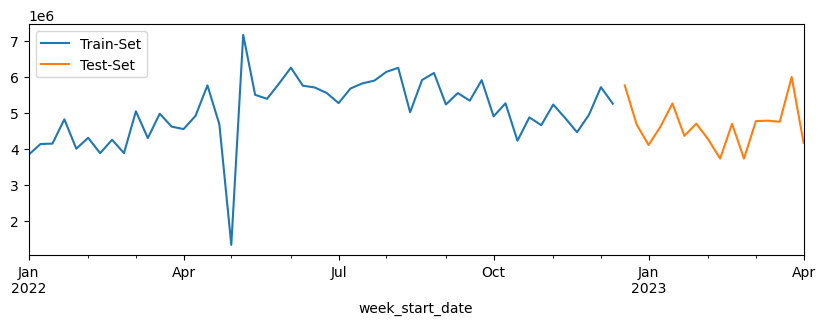

In [24]:
# Plot the train and test data after splitted
week_quantity_ts.squeeze()[:train_size].plot.line(figsize=(10,3))
week_quantity_ts.squeeze()[train_size:].plot.line(figsize=(10,3))
plt.legend(['Train-Set', 'Test-Set'])

The train and test data are splitted in the middle of December 2022.

### Feature Scaling

We will check the skewness of X data before scaling the X

In [25]:
print ("Skewness of X data : ",skew(X_train))

Skewness of X data :  [-1.15599237 -1.27166389]


The skewness is less than -0.5, so we consider the X have negative skewness. Therefore, we will use MinMaxScaler to transform the X data into the lower scale so it will make the model lighter to predict the X.

In [26]:
# Scaling the X data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Definition

- The model used is the Linear Regression model with a pipeline to make the model optimize
- We set the fit_intercept into `True` so the regression algorithm will estimate the intercept term of the line, which represents the predicted value of the dependent variable (y) when the independent variable (x) is zero. This means that the regression line will not necessarily pass through the origin of the plot
- We use PolynomialFeatures so we will make new polynomial features up to the 4th degree based on the existing features (X). We will check how the 4th degree equation using X features will affect to our model

## Model Training

In [27]:
# Create the pipeline with Polynomial Features
model_lr_pipe = make_pipeline(PolynomialFeatures(4),
                      LinearRegression(fit_intercept=True))

# Train the model
model_lr_pipe.fit(X_train_scaled,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=4)),
                ('linearregression', LinearRegression())])

## Model Evaluation

We will use MAE and R2 score to see the performance of the models based on absolute error and proportion of variance in the y. The reason why we use MAE and not RMSE is because, we still have a natural outlier so we want a metric that is less sensitive to outliers, therefore MAE is the right metric for this case.

In [28]:
# predict the y
y_pred_train = model_lr_pipe.predict(X_train_scaled)
y_pred_test = model_lr_pipe.predict(X_test_scaled)

# Evaluate the actual and predicted data
print('Train MAE:',mean_absolute_error(y_train,y_pred_train))
print('Test MAE:',mean_absolute_error(y_test,y_pred_test))

print('Train R2:',r2_score(y_train,y_pred_train))
print('Test r2:',r2_score(y_test,y_pred_test))

print ('\nPercentage of Errors = {:.2f}%'.format(mean_absolute_error(y_test,y_pred_test)/week_quantity.median()[1] *100))

Train MAE: 429629.52209971426
Test MAE: 597298.8086099625
Train R2: 0.5462805556608741
Test r2: -0.5670823776153324

Percentage of Errors = 12.17%


- The `model is a little bit overfit`, judging from the MAE test score is greater than MAE train score with `120k difference`
- MAE score indicates that our `model has about +/- 590K (12.17%) margin of error` when predicting the quantities of sold products
- R2 score in test is minus, it can indicates that our model is indeed overfitting and it does not explain a significant proportion of the variance in the dependent variable, even in R2 training score explain the 54% of variance of the data, the `R2 score in test data are litlle bit in a unacceptable range`

In [29]:
# Combines All Prediction into One NumPy Array

y_pred_all = np.concatenate([week_quantity_ts.squeeze()[:2], y_pred_train, y_pred_test], axis=0)

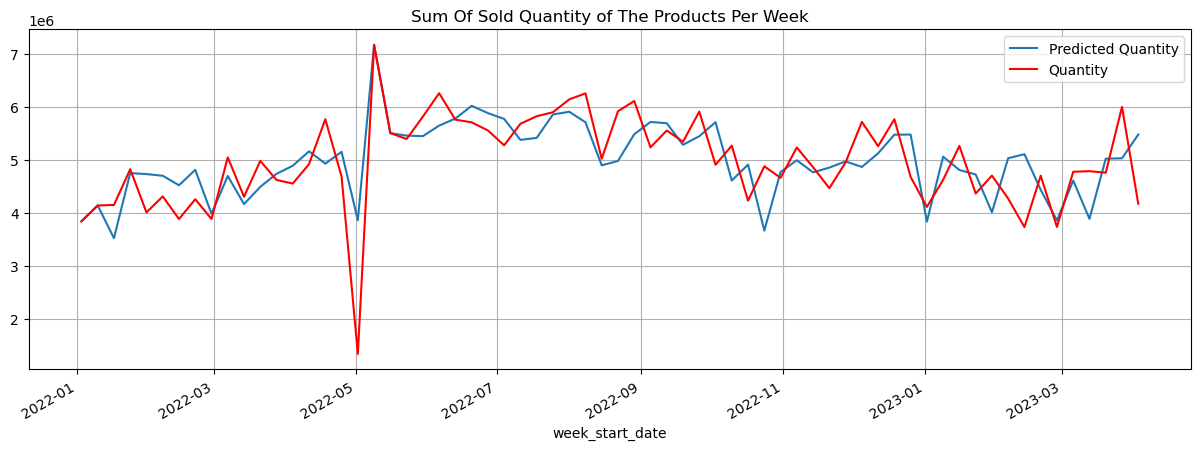

In [30]:
# Plot the quantity and predicted quantity
plt.figure(figsize=(15, 5))
plt.plot(week_quantity_ts.squeeze().index, y_pred_all,label='Predicted Quantity')
week_quantity_ts.squeeze().plot(color='red',label='Quantity')
plt.title("Sum Of Sold Quantity of The Products Per Week")
plt.legend()
plt.grid()
plt.show()

- Judging from the pattern as shown as the graph above, `the model can already captured the most of pattern` from the real data
- The `model`, in terms of predicting the number of products sold, `is rather sensitive to the data valley on May 2, 2022`. The model would drop drastically every few months (every 4 or 6 months), as seen in January, May, and November 2022, where the predicted quantity dropped drastically, which should not have dropped that far
- The `impact` of this kind of prediction is that the model will often predict a drop in sales, which can make `marketing resources less effective`

Now, let's see how well this model predict the 12 weeks ahead from the recent data.

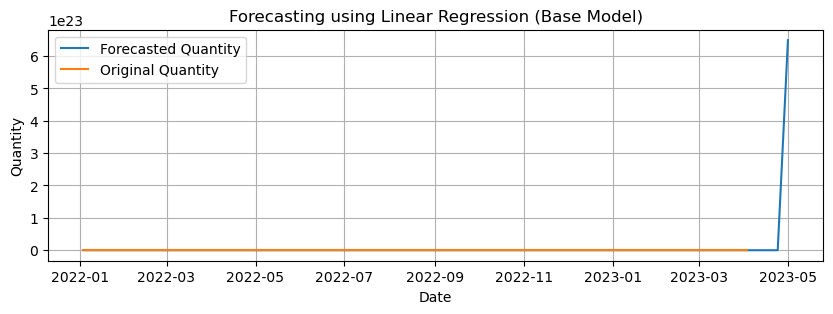

In [31]:
# Forecasting 12 weeks ahead from real data
week_quantity_ts_forecast=week_quantity_ts.squeeze().copy()
for i in range(4):
    X_inf = np.array(week_quantity_ts_forecast[-2:].values).reshape(1, -1)
    X_scaled_inf = scaler.transform(X_inf)
    new_idx=week_quantity_ts_forecast.index[-1]+datetime.timedelta(days=7)
    week_quantity_ts_forecast[new_idx] = round(model_lr_pipe.predict(X_scaled_inf)[0])

fig, ax = plt.subplots(nrows=1,figsize=(10,3))
ax.plot(week_quantity_ts_forecast)
ax.plot(week_quantity_ts['quantity'])
ax.set_title('Forecasting using Linear Regression (Base Model)')
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
ax.legend(['Forecasted Quantity', 'Original Quantity'])
plt.grid()

On contrary, this model cannot predict well on inference data, instead, `the forecasted quantity explodes at high quantity counts`. It seems that our model is only good when predicting training and test data.

## Model Improvement

- Increase the degree in PolynomialFeatures, we want to check how it will affect the model
- Adding Regularization\
We will see how if we add regularization Ridge to improve the model. *Ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization* is a technique used to prevent overfitting by adding a penalty term to the regression equation, which is proportional to the square of the magnitude of the coefficients. Source (https://livebook.manning.com/book/machine-learning-with-r-the-tidyverse-and-mlr/chapter-11)

In [32]:
# Create the pipeline with Polynomial Features
model_lr_pipe2 = make_pipeline(PolynomialFeatures(30),
                      Ridge(alpha=0.1))
model_lr_pipe2.fit(X_train_scaled,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=30)),
                ('ridge', Ridge(alpha=0.1))])

In [33]:
# predict the y
y_pred_train2 = model_lr_pipe2.predict(X_train_scaled)
y_pred_test2 = model_lr_pipe2.predict(X_test_scaled)

# Evaluate the actual and predicted data
print('Train MAE:',mean_absolute_error(y_train,y_pred_train2))
print('Test MAE:',mean_absolute_error(y_test,y_pred_test2))

print('Train R2:',r2_score(y_train,y_pred_train2))
print('Test r2:',r2_score(y_test,y_pred_test2))

print ('\nPercentage of Errors = {:.2f}%'.format(mean_absolute_error(y_test,y_pred_test2)/week_quantity.median()[1] *100))

Train MAE: 472499.35590006376
Test MAE: 510574.1883054846
Train R2: 0.34842533548654386
Test r2: -0.3754400518793004

Percentage of Errors = 10.40%


- The model is `less overfit than the base model`, judging from the MAE test score is greater than MAE train score with only 40k difference
- MAE score indicates that our `model has about +/- 510K (10.4%) margin of error` when predicting the quantities of sold products
- R2 score in test is still a minus, it can indicates that our model is indeed overfitting and it does not explain a significant proportion of the variance in the dependent variable, but it is less overfit than the base model judging from the `R2 score in improved model is greater than base model`

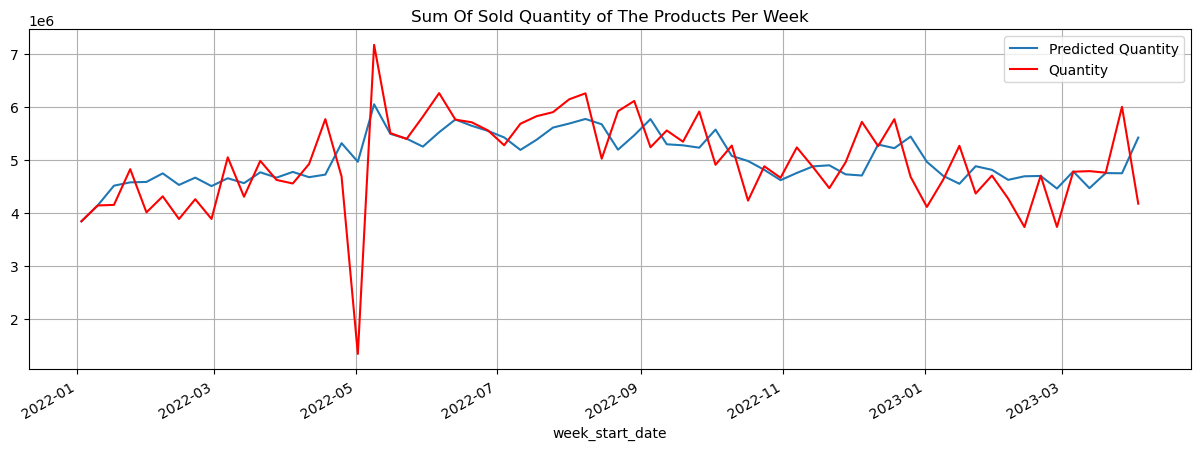

In [34]:
# Combines All Prediction into One NumPy Array

y_pred_all2 = np.concatenate([week_quantity_ts.squeeze()[:2], y_pred_train2, y_pred_test2], axis=0)

# Plot evalutaion of the model
plt.figure(figsize=(15, 5))
plt.plot(week_quantity_ts.squeeze().index, y_pred_all2,label='Predicted Quantity')
week_quantity_ts.squeeze().plot(color='red',label='Quantity')
plt.title("Sum Of Sold Quantity of The Products Per Week")
plt.legend()
plt.grid()
plt.show()

- The model, in terms of predicting the number of products sold, `is not sensitive to the data valley on May 2 (outlier)`, 2022. The pattern of the data can already be captured adequately from this model
- Looking at the pattern depicted from the model prediction results, it can be seen that `the model has a lag to the sales peaks`, such as in the last week of April 2022, the sales peak that should have been at the end of April was predicted in early May 2022. Then in the last week of August 2022 when the sales peak occurred, it was predicted in the second week of September 2022, etc.
- The impact of this kind of prediction is that `the model will not be able to predict where the lowest valley occurs`, especially during Eid al-Fitr. Moreover, the Eid season can only be captured if we use the Hijri calendar, whereas we use the Gregorian calendar. This can also happen because we do not have long enough data to capture seasonality or trends in the time series data.

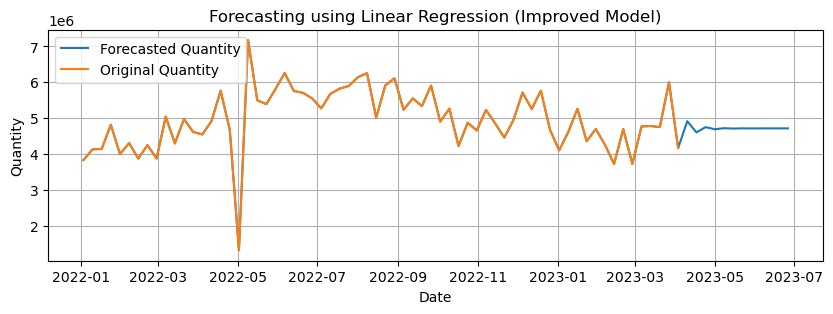

In [35]:
# Forecasting 12 weeks ahead from real data
week_quantity_ts_forecast=week_quantity_ts.squeeze().copy()
for i in range(12):
    X_inf = np.array(week_quantity_ts_forecast[-2:].values).reshape(1, -1)
    X_scaled_inf = scaler.transform(X_inf)
    new_idx=week_quantity_ts_forecast.index[-1]+datetime.timedelta(days=7)
    week_quantity_ts_forecast[new_idx] = round(model_lr_pipe2.predict(X_scaled_inf)[0])

fig, ax = plt.subplots(nrows=1,figsize=(10,3))
ax.plot(week_quantity_ts_forecast)
ax.plot(week_quantity_ts['quantity'])
ax.set_title('Forecasting using Linear Regression (Improved Model)')
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
plt.grid()
ax.legend(['Forecasted Quantity', 'Original Quantity'])

In [36]:
# describe of the real data
week_quantity.describe()

,week,quantity
count,67.000000,6.700000e+01
mean,22.910448,4.893713e+06
std,15.945676,1.044439e+06
min,1.000000,1.288080e+05
25%,9.000000,4.337716e+06
50%,20.000000,4.907074e+06
75%,36.500000,5.619344e+06
max,52.000000,7.172144e+06


- It seems that after forecasting the next 12 weeks of the latest data (from the graph), the model shows better results than the base model. `The predicted range of quantities sold` shows an acceptable `range of 4M-5M`, which is within `25%-75% of the real data` (from the describe of the data).
- The model can already forecast up to 12 weeks ahead, but `after 6 forecasting weeks ahead, the model produces forecasts that refer to 1 similar value`, around 470K quantities, which is `close to mean of the real data`. So, it is recommended to predict 4 to 5 weeks ahead only

__Model Conclusion__ :
- The `best model is obtained after improving the model using the regularization and increasing the degree of PolynomialFeatures`. 
- Our model can already forecast up to 5 weeks ahead with window size of 2. 
- `The weakness` of the model is that our model still has a lag when predicting the peak for each period. 
- `The strenght` of the model is that it can already forecast the quantities of products sold per week when the actual data is close to the mean data or the maximum forecast up to 5 weeks ahead only.

__Suggestions for further improvement__ :
- Prediction using the Hijri calendar when training the model in order to pick up seasonal patterns during Eid al-Fitr.
- It is better to use longer data (at least 3 years) in order to take seasonal or trend patterns from data at least 3 times.

## Model Saving

In [37]:
# Save the Files

import pickle

with open('model_lr_pipe2.pkl', 'wb') as file_1:
    pickle.dump(model_lr_pipe2, file_1)  
    
with open('scaler.pkl', 'wb') as file_2:
    pickle.dump(scaler, file_2)

## Conclusions

- The total products sold per week was about 4.9M at the 50% percentile and the average of the data. As Eid approached, the total number of sales decreased and resulted in a drastic drop in the number of products sold, down to 1.2M.
- Total unique products sold were 2309 items with the highest sale per item being 67 counts and the lowest sale being 1 count
- In the next period (next 4 weeks), we will sell around 4-5M products with a margin of error of +/- 510K.
- The best linear regression model was obtained using Ridge regularization and PolynomialFeatures with degree = 30 with the best ability to predict for the next 4-5 weeks.